# Example 3: Using Open Seismic

In this example, you will learn how to use custom preprocessing, postprocessing, and model inference scripts in Open Seismic.

### Sections
3.1 **Defining the JSON Configuration:** We will go over how to define a JSON file used in Open Seismic for specifying needed files.<br/>
3.2 **Organization of Files:** We will go over how to organize your files in a digestable format to reduce mounts.<br/>
3.3 **Using Open Seismic's Docker Image:** We will mount our local volume to an Open Seismic container and conduct inference on our data.<br/>

## Imports

Here are some initial imports and global variables that we need to set up before moving forward. Make sure to run `pip install -r requirements.txt` and build/pull the docker image for Open Seismic.

In [1]:
import json
from pathlib import PurePath
import os
import numpy as np
import matplotlib.pyplot as plt

def list_files(startpath):
    for root, dirs, files in os.walk(startpath):
        # if 'ipynb' in root or 'ipynb' in dirs or 'ipynb' in files:
        #     continue
        # if 'pycache' in root or 'pycache' in dirs or 'pycache' in files:
        #     continue
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print('{}{}/'.format(indent, os.path.basename(root)))
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print('{}{}'.format(subindent, f))

open_seismic_docker = 'open_seismic'
assets_path = PurePath('assets', 'example3_assets')
os_path = PurePath(os.getcwd()).parent

models_path = os_path.joinpath('models')
models_mount = f' -v {models_path}:/core/python/models/'

## Section 3.1: Defining the JSON Configuration

In this section, we will go over how to define the JSON file that will be used to direct Open Seismic to the correct file. Below is a description of the JSON file in JSON-like format:
```
{
/*
pre_model_optimizer_params:

The pre_model_optimizer_params specify the script path and the script parameters. 
The script.sh file can be used as a conduit for specifying Python scripts. Use 
argparse to ingest the parameters defined after the script. 

*/
    "pre_model_optimizer_params": {
        "script": "path/to/conversion/script.sh", 
        "script_param_1": "...", // param names will be defined by your script
        "script_param_2": "..."  // conversion script must use argparse
    },
    
/*
model_optimizer_params:

The model_optimizer_params section is for specifying model optimizer configuration 
values. Please refer to OpenVINO's documentation for details.

*/
    "model_optimizer_params": {
        "input_model": "path/to/model.ext", // MO params defined by OpenVINO
        "input_shape": "[...]",
        "data_type": "FP32",
        "output_dir": "output_dir/",
        "model_name": "name-of-model"
    },
    
/*
inference_params:

The inference_params section is for specifying inference configurations for Open Seismic. 

*/
    "inference_params": {
        "data": "path/to/data/",
        "model": "path/to/model_files/and/model_scripts/", 
        "infer_type": "<sync/async/cube_sync/cube_async/section_sync/section_async>",
        <"benchmarking": ''>, // skip to disable model benchmarking
        "output": "path/to/output_dir/",
        "streams": "num_streams",
        "slice": "<full/inline/crossline/timeslice>",
        "subsampl": "stride_of_cubed_inference",
        "slice_no": "slice_number",
        "im_size": "side_length_of_cube_for_cubed_inference",
        "return_to_fullsize": "<True/False>"
    },
    
/*
visualize_params:

The visualize_params section are used for specifying the Open Seismic visualization 
configurations. This might be handy if you want to qualitatively analyze the output.

*/
    "visualize_params": {
        "input": "path/to/output_dir/", // == "output" param in "inference_params"
        "output": "vis_folder/", // folder name where to dump outputs
        "model_type": <"facies", "salt", "fault">
    }
}
```

Now that we have gone over the JSON file definition, let's look at an example JSON config for concreteness (we leave out the visualization for simplicity):

In [2]:
json_path = assets_path.joinpath('example3_config.json')
with open(str(json_path), 'rb') as f:
    json_config = json.load(f)
print(json.dumps(json_config, indent=4))

{
    "pre_model_optimizer_params": {
        "script": "mnt/example3_optimization/pytorch2onnx.sh",
        "path_to_state": "mnt/example3_optimization/salt.pt",
        "model_output": "mnt/example3_optimization/salt.onnx"
    },
    "model_optimizer_params": {
        "input_model": "mnt/example3_optimization/salt.onnx",
        "input_shape": "[1,1,65,65,65]",
        "data_type": "FP32",
        "output_dir": "mnt/example3_scripts",
        "model_name": "salt"
    },
    "inference_params": {
        "data": "example3_data/",
        "model": "mnt/example3_scripts/",
        "infer_type": "fine_cube_sync",
        "return_to_fullsize": "True",
        "output": "example3_output"
    }
}


If you analyze the configuration JSON above, you can see that we will not only conduct inference, but we will also convert our original model (.pt) into a popular framework equivalent (.onnx) and optimize it using the model optimizer. All these topics were introduced in Example 1. Now, instead of separating these conversion, optimization, and inference steps, we have defined conversion scripts to do the conversion and ingest it as part of the Open Seismic pipeline.

## Section 3.2: Organization of Files

In this section, we will go over how to organize your files. This format was introduced to reduce the number of mounts that you need to do. Below, we have defined the recommended directory structure that we will mount to the Docker container:
```
my_local_dir/
    config.json
    my_data_folder\
        ...
        data_file_i
        ...
    my_optimization_folder\
        converter_script.sh
        converter_script_helper.py
    my_scripts_folder\
        model.py
        preprocessor.py
        postprocessor.py
        modelname.xml
        modelname.bin
        modelname.mapping
```

Now, let's take a look at the file directory structure that we will use for Example 3. You can see the similarities.

In [3]:
list_files(str(assets_path))

example3_assets/
    example3_data
    example3_config.json
    example3_scripts/
        postprocessor.py
        preprocessor.py
        salt.bin
        model.py
        salt.mapping
        salt.xml
        __pycache__/
            model.cpython-36.pyc
            postprocessor.cpython-36.pyc
            preprocessor.cpython-36.pyc
    runs/
        January13_04-50-57_PM_2021/
            info.log
            example3_output/
                f3_8bit.segy-input/
                    out.npy
    example3_optimization/
        salt.onnx
        salt.pt
        texture_net.py
        pytorch2onnx.py
        pytorch2onnx.sh
        __pycache__/
            texture_net.cpython-36.pyc


## Section 3.3: Using Open Seismic's Docker Image

In this section, we will finally mount our local directory to Open Seismic's Docker container to:
1. Convert our original model with the help of our custom conversion scripts
2. Optimize our model using OpenVINO's model optimizer
3. Conduct inference in Open Seismic using our newly optimized IR

Before we begin, there are two more mount we should be aware of: the `runs` local directory and the `models` local directory. The `runs` directory will store the output of the inference task, while `models` will hold the given models from Open Seismic. We will also include a data mount point to the F3 data block in order to reduce copy files from one directory to another.

### Steps
1. Run the cell below to construct the Open Seismic Docker command.

In [4]:
cwd = os.getcwd()
local_dir = PurePath(cwd).joinpath(assets_path)
run_dir = PurePath(cwd).joinpath(assets_path).joinpath('runs')
data_dir = os_path.joinpath('data_mnt', 'Dutch_F3_data')
os_input = '/core/mnt/example3_config.json'

local_mount = f'-v {local_dir}:/core/mnt/'
run_mount = f'-v {run_dir}:/core/runs/'
data_mount = f'-v {data_dir}:/core/example3_data/'
mounts = f'{local_mount} {run_mount} {data_mount} {models_mount}'

os_cmd = f"docker run {mounts} {open_seismic_docker} ./run.sh -c {os_input}"
os_cmd

'docker run -v /home/akhorkin/Repositories/open_seismic/examples/assets/example3_assets:/core/mnt/ -v /home/akhorkin/Repositories/open_seismic/examples/assets/example3_assets/runs:/core/runs/ -v /home/akhorkin/Repositories/open_seismic/data_mnt/Dutch_F3_data:/core/example3_data/  -v /home/akhorkin/Repositories/open_seismic/models:/core/python/models/ open_seismic ./run.sh -c /core/mnt/example3_config.json'

2. Run the cell below to use Open Seismic! Note that if you get an error, try to clean up the mounted directory by deleting `.ipynb_checkpoints` directories and `__pycache__` directories in the data folders. If you run into permission errors, make sure to `chmod` the .sh files.

In [5]:
! {os_cmd}

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/core/mnt/example3_optimization/salt.onnx
	- Path for generated IR: 	/core/mnt/example3_scripts
	- IR output name: 	salt
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,1,65,65,65]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	False
ONNX specific parameters:
Model Optimizer version: 	2021.1.0-1237-bece22ac675-releases/2021/1

[ SUCCESS ] Generated IR version 10 model.
[ SUCCESS ] XML file: /core/mnt/example3_scripts/salt.xml
[ SUCCESS ] BIN file: /core/mnt/example3_scripts/salt.bin
[ SUCCESS ] Total execution time: 2.93 seconds. 
[ SUCC

3. As a bonus, we will visualize our output. This is also a chance to get familiar with the output file structure. Replace `name_of_output_dir` with the output timestamp of interest and run the cells below to see the output.

In [6]:
name_of_output_dir = 'January13_04-50-57_PM_2021'
output_name = 'f3_8bit.segy-input' + os.sep + 'out.npy'
output_path = assets_path.joinpath(
    'runs', name_of_output_dir, 'example3_output', output_name)
output_path

PurePosixPath('assets/example3_assets/runs/January13_04-50-57_PM_2021/example3_output/f3_8bit.segy-input/out.npy')

Notice the path generated to get the output. The output is stored in the `runs` directory, but we need to traverse the file structure by (1) timpstamp, then (2) output folder name, and finally, (3) input name. There are also cases where you need to go down one more level based on the network's output layer. The output will be stored as a .npy file.

In [7]:
input_name = 'f3_8bit.segy'
input_path = data_dir.joinpath(input_name)
input_path

PurePosixPath('/home/akhorkin/Repositories/open_seismic/data_mnt/Dutch_F3_data/f3_8bit.segy')

Now, we will visualize our input data with our output from the network.

In [8]:
import segyio

# Loading Data
data = segyio.tools.cube(str(input_path))
data = np.moveaxis(data, -1, 0)
data = np.ascontiguousarray(data,'float32')

# Loading Output
class_cube = np.load(str(output_path))

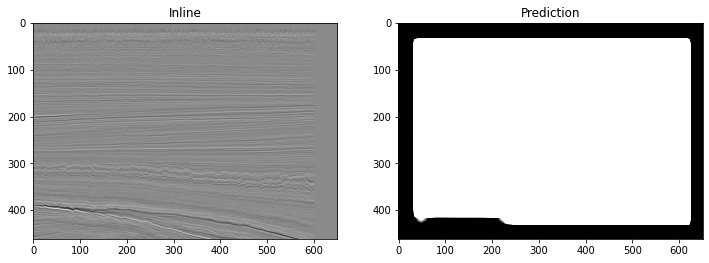

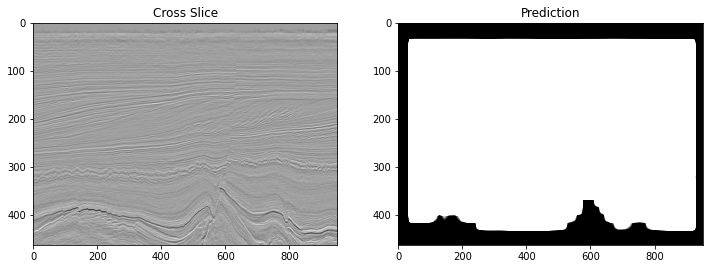

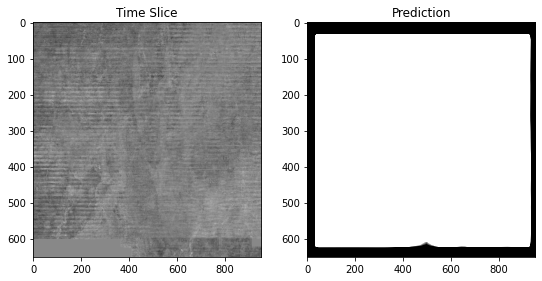

In [9]:
k1,k2,k3 = 40,200,50
gx1 = data[k1,:,:]
gy1 = class_cube[0][k1,:,:]
gx2 = data[:,k2,:]
gy2 = class_cube[0][:,k2,:]
gx3 = data[:,:,k3]
gy3 = class_cube[0][:,:,k3]

#Inline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx3,cmap=plt.cm.gray)
plt.title("Inline")
p2 = plt.subplot(1,2,2)
p2.imshow(gy3,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")

#Crossline slice
fig = plt.figure(figsize=(12,12))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx2,aspect=1.5,cmap=plt.cm.gray)
plt.title("Cross Slice")
p2 = plt.subplot(1,2,2)
p2.imshow(gy2,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")

#Time slice
fig = plt.figure(figsize=(9,9))
p1 = plt.subplot(1, 2, 1)
p1.imshow(gx1,aspect=1.5,cmap=plt.cm.gray)
plt.title("Time Slice")
p2 = plt.subplot(1,2,2)
p2.imshow(gy1,aspect=1.5,interpolation="bilinear",vmin=0.4,vmax=1.0,cmap=plt.cm.gray)
plt.title("Prediction")
plt.show()

As you can see, the salt identification model is able to form the shape of the salt bodies that exist within the seismic data.

## Summary

Congratulations! You are now able to use Open Seismic! In this example, you learned about:
1. The JSON configuration file
2. The recommended mount directory strategy
3. How to use Open Seismic with the files we have discussed in this example and previous examples

If you are interested in exploring more of Open Seismic, go to the demos located in the `app` directory: `demo_fault`, `demo_salt`, and `demo_facies`. Here, you will see how to run Open Seismic's different inference tasks. Finally, if you want to get up and running with your own custom model and scripts but don't know where to start, please follow `Example4.ipynb` for a template on how to get started.